# Term Project (Data Analysis): IoT Fundamentals 2102541
---
*For educational purposes*

<u>*Objective:* Work with REST API to request for Data, Study Machine Learning applying</u>

*Term Project by Patcharanat P.*<br>

**Data Source : DATA.POLICE.UK** *(Last updated: 22-03-01 [ISO format])*

Police API Documentation:
* [Link to API Documentation](https://data.police.uk/docs/)

Crime categories:
* [Link to Crime catagories document](https://data.police.uk/docs/method/crime-categories/)

Crime at a location:
* [Link to Crime at a location](https://data.police.uk/docs/method/crimes-at-location/)

### About
    Data is about crimes occuring at a specific location that is Victoria Square at Birmingham, United Kingdom. It's open data about crime in England, Wales and Northern Ireland, which is made available under the Open Government Licence v3.0.

### Table of Contents
* Import Library
* Data Preparing (REST API)
* Exploratory Data Analysis: EDA
* Machine Learning
* Reference

---

### Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

---

### Data Preparing (REST API)

#### 1. Call REST API to collect all needed data
* Crime Catagories
* Crime recorded last 2 years (maximum period available to call from data provider)

In [27]:
data_category = pd.read_json("https://data.police.uk/api/crime-categories?date=2022-04")
data_category

,url,name
0,all-crime,All crime
1,anti-social-behaviour,Anti-social behaviour
2,bicycle-theft,Bicycle theft
3,burglary,Burglary
4,criminal-damage-arson,Criminal damage and arson
5,drugs,Drugs
6,other-theft,Other theft
7,possession-of-weapons,Possession of weapons
8,public-order,Public order
9,robbery,Robbery


I will create a dict that can be use for categories mapping for a cleaned visualization.

In [30]:
mapping_dict = dict()
for i in range(data_category.shape[0]) :
    mapping_dict[data_category.iloc[i, 0]] = data_category.iloc[i, 1]

Due to a API request provides only record of 1 month, So I need to iterate API request (with different URL) to collect enough data for prediction.

In [4]:
# Use REST API to request the crimes data last 2 years (Last update: 22-03)
# ISO format: YYYY-MM
# call for data from 2020-01 to 2022-03
data_all = list() # for preparing to aggregate all called api, then I will concatenate all data into one DataFrame
year = 20
while year < 23 :
    month = 1
    while month < 13 :
        if len(str(month)) == 1 : # change 1 to 01 for month prefix assigned as month_index
                month_index = f'0{month}'
        else :
            month_index = month
        # Pull data each year from the api
        try : # explained in below cell
            exec(f'data_20{year}_{month} = pd.read_json("https://data.police.uk/api/crimes-at-location?date=20{year}-{month_index}&lat=52.48&lng=-1.9025")')
            # keep the data in data_all list
            exec(f'data_all.append(data_20{year}_{month})')
            month += 1
        except :
            pass
        if year == 22 and month == 4 : # break loop after data 2022-02 pulled successfully
            break
    year += 1
# result is data_all = [data_2020_1, data_2020_2, data_2020_3, ... , data_2022_3]

<u>For try and except block:</u> I have tried to call API from the website and <b>HTTP 500 error</b> occurred due to a failed API request.<br>
solution from <i>[Line Developers](https://developers.line.biz/en/docs/messaging-api/retrying-api-request/)</i> said the API request need retrying.

#### 2. Create DataFrame, and Select necessary columns

In [5]:
# Union all pulled data into a DataFrame, then assign as df
df = pd.concat(data_all)
df.head()

,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month
0,anti-social-behaviour,Force,"{'latitude': '52.480173', 'street': {'id': 125...",,None,,80681683,,2020-01
1,anti-social-behaviour,Force,"{'latitude': '52.480173', 'street': {'id': 125...",,None,,80682525,,2020-01
2,other-theft,Force,"{'latitude': '52.480173', 'street': {'id': 125...",,{'category': 'Investigation complete; no suspe...,b971017bc1636ab55ce4472dbbc0bcfc96a01824aa5719...,80674586,,2020-01
3,other-theft,Force,"{'latitude': '52.480173', 'street': {'id': 125...",,{'category': 'Investigation complete; no suspe...,ab7b9576e5aa11eb145ebdce66a605599046a188f7c878...,80677002,,2020-01
4,violent-crime,Force,"{'latitude': '52.480173', 'street': {'id': 125...",,{'category': 'Investigation complete; no suspe...,0d292878bcb169d16db16b11dde972dee74ced61e5c1be...,80680495,,2020-01


In [6]:
df.info()
# DataFrame (df) include 237 rows and 9 colums

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237 entries, 0 to 7
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   category          237 non-null    object
 1   location_type     237 non-null    object
 2   location          237 non-null    object
 3   context           237 non-null    object
 4   outcome_status    198 non-null    object
 5   persistent_id     237 non-null    object
 6   id                237 non-null    int64 
 7   location_subtype  237 non-null    object
 8   month             237 non-null    object
dtypes: int64(1), object(8)
memory usage: 18.5+ KB


From 2 cells above, we can see that data in all of these columns except "category", and "month" are useless for analysis.<br>
--> Only 3 things, we consider it as important, are <b>"Category of crime that occurrs", "When it occurs", and "Number of times that each category occurs"</b>

In [7]:
# select only necessary data for analysis
df = df[["category", "month"]]
df

,category,month
0,anti-social-behaviour,2020-01
1,anti-social-behaviour,2020-01
2,other-theft,2020-01
3,other-theft,2020-01
4,violent-crime,2020-01
...,...,...
3,public-order,2022-02
4,violent-crime,2022-02
5,violent-crime,2022-02
6,violent-crime,2022-02


In [8]:
# set month column to date variable type
df['month'] = pd.to_datetime(df['month'])
df['month'] = df['month'].dt.date.apply(lambda x: x.strftime('%Y-%m'))
# https://stackoverflow.com/questions/50511640/how-to-convert-string-to-datetime-without-days-in-pandas

,category,month
0,anti-social-behaviour,2020-01
1,anti-social-behaviour,2020-01
2,other-theft,2020-01
3,other-theft,2020-01
4,violent-crime,2020-01


#### 3. Check if any missing value exists

In [9]:
df.isnull().sum()

category    0
month       0
dtype: int64

Data is cleaned and ready for the next step.

---

### Exploratory Data Analysis: EDA

In Last 2 Years, which type of crimes has the most frequently occurred.

In [10]:
sns.set(style='darkgrid', color_codes=True)

Text(0.5, 0, 'Period of time')

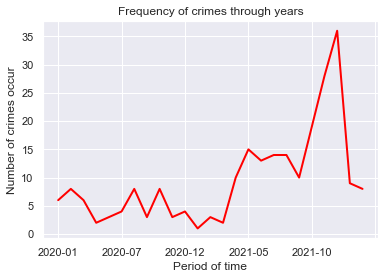

In [21]:
data_plot = df.groupby('month').count()

ax = data_plot.plot(color='red',
               legend=False,
               linewidth=2)
ax
plt.title('Frequency of crimes through years')
plt.ylabel('Number of crimes occur')
plt.xlabel('Period of time')

<AxesSubplot:title={'center':'Crime categories ocurring Comparison from last 2 years'}, ylabel='Frequency'>

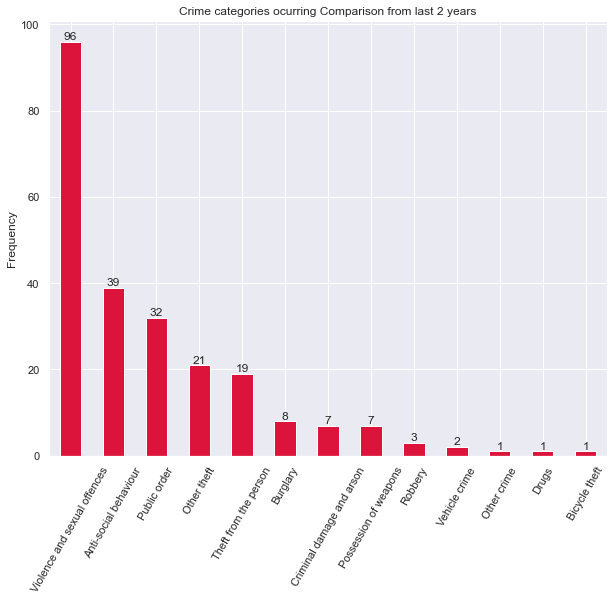

In [40]:
# plot but use category mapping for more cleaned visualisation
ax = df['category'].map(mapping_dict).value_counts().plot(kind="bar",
                                                     color="crimson",
                                                     figsize=(10, 8))

plt.xticks(rotation=60)
plt.ylabel('Frequency')
plt.title('Crime categories ocurring Comparison from last 2 years')

ax.bar_label(ax.containers[0]) # https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

plt.show()

In [149]:
crime_sum = df['category'].value_counts().sum()
print('total crimes occur during 2 years: ' + str(crime_sum))

number_of_month = len(df['month'].unique())
print('average crimes occur per month: ' + str(crime_sum / number_of_month))

total crimes occur during 2 years: 237
average crimes occur per month: 9.48


---

### Machine Learning Testing
    For this dataset, I will use Sklearn DummyClassifier, which does not provide any insight about the data using only simple rule for prediction. The classifier's behavior is completely independent of the training data as the trends, but instead, uses one of 'strategies' to predict the class label. Because of data's limitation, I decide to use the most simple Classifier, which usually be used as baseline, just to show only concept of applying machine learning to the data ignoring efficiency of Model's prediction. 

#### 1. Pre-Processing<br>

First, For classification model, the ML model accept only numerical values, so we need to convert all crime catagorical variables into label values 
(different category mapped to different integers). And LabelEncoding will be used in this situation.

In [114]:
# Label encoding
# Note that with categorical variable containing many multiple labels, OnehotEncoder will expand the space drmatically making computaion more costly.
# and Label Encoding cannot work for linear models, SVMs, or neural networks which I'm not going to use in this project. 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df1 = pd.DataFrame(df['category'].map(mapping_dict))
df1['Encoded1'] = le.fit_transform(df1['category'])

# duplicate column
df1['Encoded2'] = df1['Encoded1']
df1.head(8)

,category,Encoded1,Encoded2
0,Anti-social behaviour,0,0
1,Anti-social behaviour,0,0
2,Other theft,6,6
3,Other theft,6,6
4,Violence and sexual offences,12,12
5,Violence and sexual offences,12,12
0,Burglary,2,2
1,Burglary,2,2


#### 2. Train / Fit Model

In [125]:
from sklearn.model_selection import train_test_split

X = df1['Encoded1'].array
y = df1['Encoded2'].array

# split data for model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((165,), (72,), (165,), (72,))

In [136]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='stratified', random_state=0)
# with the 'stratified' strategy, estimator generate random predictions by respecting the training set class distribution.
# random_state is like random seed in random library: generating (pseudo-) random number make it give consistent result after trainings.
model.fit(X_train, y_train)

DummyClassifier(random_state=0, strategy='stratified')

#### 3. Predict

In [137]:
y_hat = model.predict(X_test)
y_hat

array([ 8,  8,  2,  6, 10, 12, 12,  7, 12,  6,  8, 10,  8,  3, 12,  8,  5,
       12,  2,  0,  8, 12,  6, 12, 12, 10, 12, 10,  6, 12,  0, 12,  2, 10,
        0,  0,  0, 12, 12, 12, 12,  0, 12,  6,  8,  8,  8,  8, 12,  3,  0,
       12,  8,  6, 12, 12,  0,  2,  0,  8,  0, 12, 12, 12, 12,  7, 12,  8,
        3,  0,  8, 12])

#### 4. Scoring

In [138]:
from sklearn.metrics import accuracy_score

a_score = accuracy_score(y_test, y_hat) # compare predicted data: y_hat with already existed data: y_test
print('Accuracy score: ' +  str(a_score.round(5)))

Accuracy score: 0.19444


You can see that it's not a good estimator alone, usually be used with other classifiers as baseline (as mentioned in article I had researched).<br>
But as a result, model can predict the data with accuracy 19.44% (Better than just randomly guess crimes occuring)<br>
And again, due to limitation of the data, It's quite hard to choose a model that fit the data properly. Although poor result of applying Machine learning, both of tasks (use REST API and Machine learning) still be done following the instruction.

#### <u>For more discussion about Classifier</u>

I did so much research on Decision Trees and Ramdom Forest Classifier, which are used in many projects of crimes prediction in google scholar.<br>
It seem to give more insight and better accuracy from both of the models, but lacking of features in the dataset and ML knowledge, I decide to <br>
use DummyClassifier which is quite simple and seems easy to understand algorithm giving a poor result of prediction. But after all done of work, It gave<br>
me a good introduction of Machine Learning (Scikit-learn) in Data Analysis, and I will definitely continue to learn it more after this course.

---

### Reference:

* [Complete Guide To Handling Categorical Data Using Scikit-Learn](https://analyticsindiamag.com/complete-guide-to-handling-categorical-data-using-scikit-learn/)
* [Sciki-learn Documentation: Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html#metrics-and-scoring-quantifying-the-quality-of-predictions)
* [Sciki-learn Documentation: Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)
* [Scikit-learn Documentation: Precision-Recall metric](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)
* [Towards Data Science: Why Using a Dummy Classifier is a Smart Move](https://towardsdatascience.com/why-using-a-dummy-classifier-is-a-smart-move-4a55080e3549)